In [1]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'

from utils.shift import *
from utils.age import *
from utils.vis import plot_performance_scatter, plot_repr_uncertainty, plot_covariate_panel

%load_ext autoreload
%autoreload 2

#load published mouse clocks
clocks = pickle.load(open('subdata/clock_coefs_mouse.pkl', 'rb'))

# GSE120132 -> GSE156557 (In vivo reprogramming)

In [2]:
#Aging - Thompson + Meer
dfa, meta = pd.read_pickle('datasets/GSE120132_GSE121141.pkl').values() 
dfa = dfa[meta.index].T 

#Reprogramming + controls (Serrano), age converted to months by dividing number of weeks on 4.34 
dfr, metr = pd.read_pickle('datasets/GSE156557.pkl').values()
metr['Age'] = np.round(metr['Age'], 1)
dfr = dfr.loc[metr.index] 

tissue_age = 'Liver'
tissue_rep = 'Liver'

if tissue_age is not None:
    meta = meta[meta['Tissue'] == tissue_age]
    dfa = dfa.loc[meta.index].dropna(axis=1)
    metr = metr[metr['Tissue'] == tissue_rep]
    dfr = dfr.loc[metr.index]

print('Age, N sites', len(dfa.columns))
print('Rep, N sites', len(dfr.columns)) 
#low number of sites are accessible for in vivo reprogramming
#due to the poor intersection of samples with each other
#nevertheless, below we show that intersected sites are enough for clock construction

Age, N sites 661406
Rep, N sites 79871


## Intersection with published clocks

Here we check how many sites intersected between published clocks and in vivo reprogramming datasets

In [4]:
#load published mouse clocks
clocks = pickle.load(open('subdata/clock_coefs_mouse.pkl', 'rb'))

for k, v in clocks.items():
    print(f"{len(dfr.columns.intersection(v.index))}/{len(v.index)} sites intersected with {k} clock.")

7/583 sites intersected with Thompson clock.
3/90 sites intersected with Petkovich clock.
16/436 sites intersected with Meer clock.


Obtained numbers of intersected sites are too small for using clocks directly or sites from them. We need to construct clocks de novo.

## Select sites using best Lasso model for de-novo clocks

16849 common sites
R2 train = 0.9796540796317688
R2 test = 0.8660089196977165
MAE train = 0.8780766894308061
MAE test = 2.1971781148437604
------------------------------
22 sites are selected by Lasso


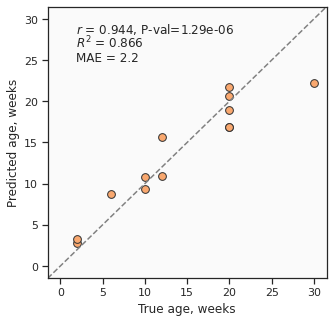

In [5]:
#select de-novo sites
sites = dfr.columns.intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

### TRAINING ###
from sklearn.linear_model import LassoCV
         
model = LassoCV(n_jobs=-1,)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)

# write coefs
lasso_sites = model.feature_names_in_[model.coef_ != 0]
lasso_coef = model.coef_[model.coef_ != 0]
clock = pd.DataFrame({'coef':lasso_coef}, index=lasso_sites)
print(f"{len(lasso_coef)} sites are selected by Lasso")

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='weeks')
plt.savefig('figs/A2_lasso_liver_performance.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [6]:
lasso_sites

array(['chr5_64753583', 'chr5_137740653', 'chr1_58306307',
       'chr17_14094815', 'chr3_38603367', 'chr3_50991274',
       'chr4_63352487', 'chr11_62576551', 'chr11_62576640',
       'chr11_79725292', 'chr6_116136420', 'chr2_126521987',
       'chr9_116085703', 'chr8_77609595', 'chr8_122630366',
       'chr14_73178261', 'chr14_77871474', 'chr12_50112452',
       'chr12_71321003', 'chr10_17334460', 'chr10_106957874',
       'chr15_11383958'], dtype=object)

Young control liver v.s. Old control liver: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.587e-02 U_stat=0.000e+00
Old control liver v.s. Old OSKM liver: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.111e-01 U_stat=3.000e+00


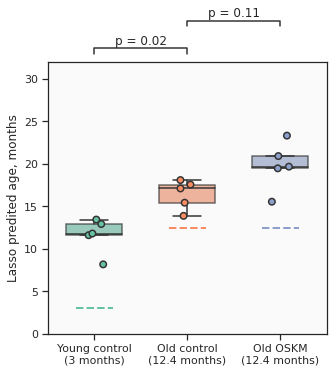

In [7]:
from statannot import add_stat_annotation
y_rep_predict = model.predict(Xr_clock)
metr_ = metr.copy()
metr_['Lasso predited age, months'] = y_rep_predict

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

PROPS = {
    'boxprops':{'edgecolor':'#333333', 'alpha':0.7},
    'medianprops':{'color':'#333333'},
    'whiskerprops':{'color':'#333333'},
    'capprops':{'color':'#333333'}
}

z = sns.boxplot(data=metr_, 
            x='Condition', 
            y='Lasso predited age, months',
            width=0.6, palette='Set2', ax=ax,
            showfliers=False, **PROPS)

sns.stripplot(data=metr_, 
            x='Condition', 
            y='Lasso predited age, months',
            s=6.5, linewidth=1.5, edgecolor="#333333",
            palette='Set2', ax=ax)
ax.set_xlabel('')
ax.set_xticklabels(['Young control\n(3 months)', 
                    'Old control\n(12.4 months)',
                    'Old OSKM\n(12.4 months)'
                    ])
ax.set_ylim([0, 32])

plt.plot([-0.2, 0.2], [3, 3], ls='--', color=sns.color_palette('Set2')[0], lw=2)
plt.plot([0.8, 1.2], [12.4, 12.4], ls='--', color=sns.color_palette('Set2')[1], lw=2)
plt.plot([1.8, 2.2], [12.4, 12.4], ls='--', color=sns.color_palette('Set2')[2], lw=2)

test_results = add_stat_annotation(ax, data=metr_, 
                                   x='Condition', 
                                   y='Lasso predited age, months',
                                   box_pairs=[("Old control liver", "Young control liver"),
                                               ("Old control liver", "Old OSKM liver"), 
                                               ],
                                   test='Mann-Whitney', 
                                   text_format='simple',
                                   loc='outside', verbose=2)

plt.savefig('figs/A2_lasso_invivo_test.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Check covariate shift

In [8]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

#conduct PCA on joined dataset
pca = PCA(2)
pca.fit(pd.concat([Xa_clock, Xr_clock]))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

cond = metr['Condition'] == 'Old OSKM liver'
Xpr_control = Xpr[~cond]
Xpr_reprog = Xpr[cond]
yr_control = yr[~cond]
yr_reprog = yr[cond]

pvar = np.round(pca.explained_variance_ratio_, 2)

22 common sites


68.18% of sites are not rejected by KS test


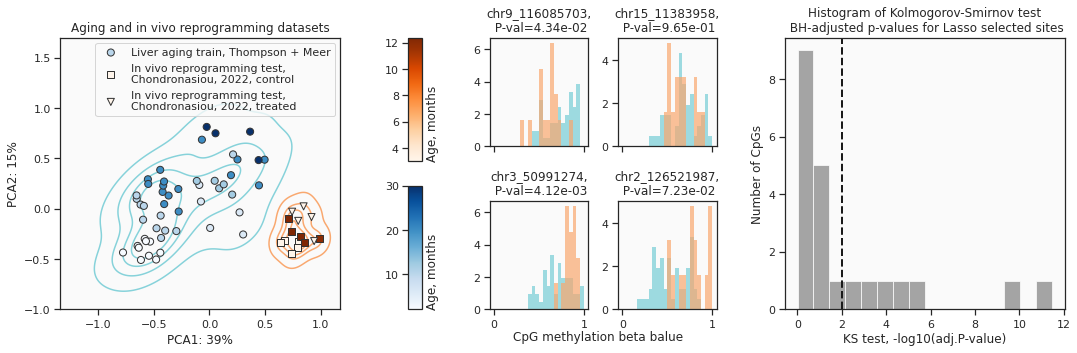

In [9]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

cbar_color_train = 'Blues'
cbar_color_test = 'Oranges'
color_train = '#86d2da'
color_test = '#f9a86f'
xa_thr = 0.05
xr_thr = 0.05
cbar_label_train = 'Age, months'
cbar_label_test = 'Age, months'
legend_label_train = 'Liver aging train, Thompson + Meer'
legend_label_test1 = f'In vivo reprogramming test, \nChondronasiou, 2022, control'
legend_label_test2 = f'In vivo reprogramming test, \nChondronasiou, 2022, treated'
ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Lasso selected sites'
pca_title = 'Aging and in vivo reprogramming datasets'
pca_legend_pos = 'upper right'
pca_xlim = None
pca_ylim = [-1, 1.7]
custom_bins = None

if custom_bins is not None:
    hist_bins = custom_bins 
else:
    hist_bins = 16

##############plotting starts here
fig = plt.figure(figsize=(18, 5), constrained_layout=True)
gs = GridSpec(2, 7, figure=fig, width_ratios=[4, 4, 0.5, 3, 3, 4, 4], wspace=0.8, hspace=0.5) 

axcbrs = gs[:, 2].subgridspec(2, 1)
axcb1, axcb2 = axcbrs.subplots()

minihists = gs[:, 3:5].subgridspec(2, 2, wspace=0.3, hspace=0.5)
minihist_subs = minihists.subplots(sharex=True)
ax0 = fig.add_subplot(gs[:, :2])
ax1 = minihist_subs[0,0]
ax2 = minihist_subs[0,1]
ax3 = minihist_subs[1,0]
ax4 = minihist_subs[1,1]
ax5 = fig.add_subplot(gs[:, 5:])

#cbars
norm_age = mpl.colors.Normalize(vmin=min(ya), vmax=max(ya))
norm_rep = mpl.colors.Normalize(vmin=min(yr), vmax=max(yr))
cb_age = mpl.colorbar.ColorbarBase(axcb2, cmap=cbar_color_train, norm=norm_age)
cb_rep = mpl.colorbar.ColorbarBase(axcb1, cmap=cbar_color_test, norm=norm_rep)
cb_age.set_label(cbar_label_train, loc='bottom')
cb_rep.set_label(cbar_label_test, loc='bottom')
axcb1.yaxis.set_ticks_position('left')
axcb2.yaxis.set_ticks_position('left')

# ax0 - PCA
ax0.set_title(pca_title)
sns.kdeplot(Xpa[:, 0], Xpa[:, 1], ax=ax0, color=color_train, levels=5, thresh=xa_thr)
sns.kdeplot(Xpr[:, 0], Xpr[:, 1], ax=ax0, color=color_test, levels=5, thresh=xr_thr)
z1_plot = ax0.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=50, label=legend_label_train, 
                    edgecolors='#333333', cmap=cbar_color_train, zorder=4)
z2_plot = ax0.scatter(Xpr_control[:, 0], Xpr_control[:, 1], c=yr_control, marker='s', s=50, label=legend_label_test1, 
                    edgecolors='#333333', cmap=cbar_color_test, zorder=4)
z2_plot = ax0.scatter(Xpr_reprog[:, 0], Xpr_reprog[:, 1], c=yr_reprog, marker='v', s=50, label=legend_label_test2, 
                    edgecolors='#333333', cmap=cbar_color_test, zorder=4)
ax0.set_xlabel(f'PCA1: {int(pvar[0]*100)}%')
ax0.set_ylabel(f'PCA2: {int(pvar[1]*100)}%')
ax0.legend(loc=pca_legend_pos)
leg = ax0.get_legend()
leg.legendHandles[0].set(edgecolor='#333333')
leg.legendHandles[1].set(edgecolor='#333333')
ax0.set_xlim(pca_xlim)
ax0.set_ylim(pca_ylim)

# ax5 - overall KS pvalues hist
ks, ksp = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='ks')
kspa = multipletests(ksp, method='hs')[1]
kspa = pd.DataFrame(index=Xa_clock.columns, data={'pval':kspa})

kspaval = -np.log10(kspa['pval'].values)
kspaval = np.where(kspaval < 100, kspaval , 100)
pct = (kspaval < 2).sum() / kspaval.shape[0] * 100
print(f'{round(pct, 2)}% of sites are not rejected by KS test')

ax5.set_title(ks_hist_title)
ax5.hist(kspaval, density=False, alpha=0.7, color='grey', bins=hist_bins)
ax5.axvline(-np.log10(0.01), color='k', ls='--', lw=2.0)
ax5.set_xlabel('KS test, -log10(adj.P-value)')
ax5.set_ylabel('Number of CpGs')

#top sites from Skin clock based on correlation with age
selected_sites = Xa_clock.corrwith(ya).abs().sort_values(ascending=False).index[:4]

#examples of sites + PSIs
fig.text(0.54, 0.04, 'CpG methylation beta balue', ha='center')
for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
    site_pval = kspa.loc[selected_sites[k], 'pval']
    ax_.hist(Xa_clock[selected_sites[k]], density=True, alpha=0.8, 
            color=color_train, 
            bins=np.linspace(0, 1, 25), 
            edgecolor='none')
    ax_.hist(Xr_clock[selected_sites[k]], density=True, alpha=0.7, 
            color=color_test, 
            bins=np.linspace(0, 1, 25), 
            edgecolor='none')
    ax_.set_title(f'{selected_sites[k]},\n P-val={"{0:.2e}".format(site_pval)}')
    ax_.set_xlim([-0.05, 1.05])

plt.savefig('figs/A1_sup_invivo.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [10]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

22 common sites


Step 1 results:
R2 train = 0.994
MAE train = 0.542
R2 test = 0.859
MAE test = 2.277
------------------------------
Step 2 results:
R2 train = 0.847
MAE train = 2.486
R2 test = 0.816
MAE test = 2.803
------------------------------


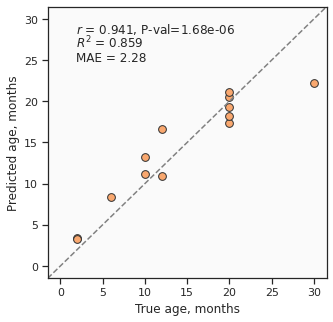

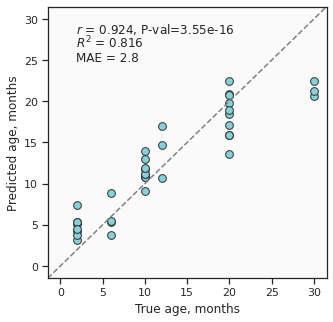

In [11]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_test, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_Thompson_Meer_train_test_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_Thompson_Meer_train_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 0.977
MAE train = 0.91
R2 test = -4.331
MAE test = 9.803
------------------------------
Step 2 results:
R2 train = -4.331
MAE train = 9.803
R2 test = 0.885
MAE test = 2.212
------------------------------


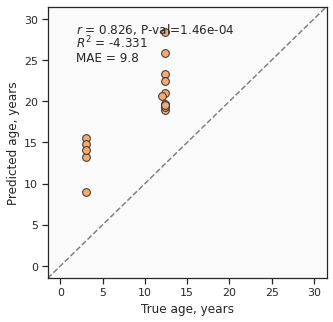

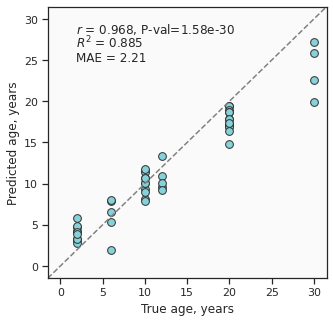

In [12]:
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=yr, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(yr, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60)
plt.savefig('figs/A3_aging_liver_Thompson_Meer_train_invivo_test_step1.pdf', format='pdf', bbox_inches='tight', units='months')
plt.show()

plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_liver_Thompson_Meer_train_invivo_test_step2.pdf', format='pdf', bbox_inches='tight', units='months')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

22 common sites
R2 train = 0.9960096689306094
R2 test = 0.8561571497320832
MAE train = 0.3951961818215894
MAE test = 1.9958283139528263
------------------------------
Resulting kernel: 16.4**2 * RBF(length_scale=2.38) + WhiteKernel(noise_level=1.01)
Resulting kernel (full): 22.3**2 * RBF(length_scale=3.6) + WhiteKernel(noise_level=2.25)


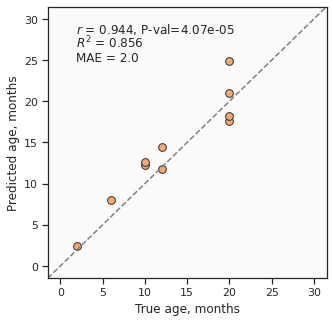

In [13]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.20, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='months')
plt.savefig('figs/A4_sup_GP_liver_(T_M)_test_performance.pdf', format='pdf', bbox_inches='tight')


model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(Xa_clock, ya)
print("Resulting kernel (full):", model.kernel_)

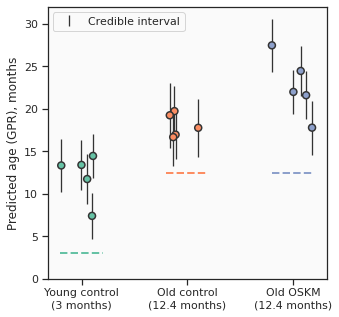

r test = 0.7865358803801518
R2 test = -3.085949665798428
MAE test = 8.358777993163502


In [14]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr_ = metr.copy()
metr_['gpr_age'] = y_test_predict_r
metr_['gpr_std'] = y_test_std_r
metr_['Age'] = metr_['Age'].astype('str')
metr_['Age'] = metr_['Age'].map({'3.0':'3', '12.0':'12.4', '12.4':'12.4'})

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
np.random.seed(10) #fix random seed for stripplot
strip = sns.stripplot(data=metr_, 
                x='Condition', 
                y='gpr_age', 
                palette='Set2',
                jitter=0.2,
                s=7, linewidth=1.5, edgecolor="#333333",
                ax=ax)
ax.set_xlabel('')
ax.set_xticklabels(['Young control\n(3 months)', 
                    'Old control\n(12.4 months)',
                    'Old OSKM\n(12.4 months)'
                    ])

yng_coords = strip.collections[0].get_offsets().data
old_coords = strip.collections[1].get_offsets().data
oskm_coords = strip.collections[2].get_offsets().data
ax.errorbar(y=yng_coords[:, 1], 
            x=yng_coords[:, 0], yerr=metr_['gpr_std'][metr_['Condition'] == 'Young control liver'], 
            linewidth=0, elinewidth=1.3, color='#333333')
ax.errorbar(y=old_coords[:, 1], 
            x=old_coords[:, 0], yerr=metr_['gpr_std'][metr_['Condition'] == 'Old control liver'], 
            linewidth=0, elinewidth=1.3, color='#333333')
ax.errorbar(y=oskm_coords[:, 1], 
            x=oskm_coords[:, 0], yerr=metr_['gpr_std'][metr_['Condition'] == 'Old OSKM liver'],
            linewidth=0, elinewidth=1.3, color='#333333', label='Credible interval')
plt.plot([-0.2, 0.2], [3, 3], ls='--', color=sns.color_palette('Set2')[0], lw=2.,)
plt.plot([0.8, 1.2], [12.4, 12.4], ls='--', color=sns.color_palette('Set2')[1], lw=2.,)
plt.plot([1.8, 2.2], [12.4, 12.4], ls='--', color=sns.color_palette('Set2')[2], lw=2. )
ax.set_ylabel('Predicted age (GPR), months')
ax.legend(loc='upper left')
ax.set_ylim([0, 32])

plt.savefig('figs/A4_invivo.pdf', format='pdf', bbox_inches='tight')
plt.show()

print(f'r test = {np.corrcoef(yr, y_test_predict_r)[0,1]}')
print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')

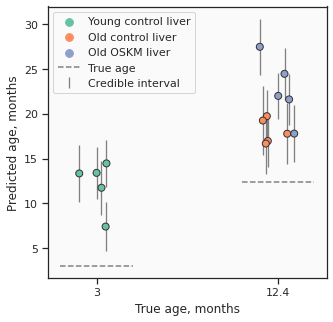

R2 test = -3.085949665798428
MAE test = 8.358777993163502


In [15]:
####################### variant 2 #########################
###########################################################
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr_ = metr.copy()
metr_['gpr_age'] = y_test_predict_r
metr_['gpr_std'] = y_test_std_r
metr_['Age'] = metr_['Age'].astype('str')
metr_['Age'] = metr_['Age'].map({'3.0':'3', '12.0':'12.4', '12.4':'12.4'})

metr_['condition'] = metr_['Condition']
metr_['condition'] = metr_['condition'].apply(lambda x: x.split(' ')[1])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
np.random.seed(10) #fix random seed for stripplot
strip = sns.stripplot(data=metr_, 
                x='Age', 
                y='gpr_age', 
                s=7,
                hue='Condition', 
                palette='Set2',
                jitter=0.1,
                edgecolor='#333333',
                linewidth=1,
                ax=ax)

isyng = metr_['Age'] == '3'
yng_coords = strip.collections[0].get_offsets().data
old_coords = strip.collections[1].get_offsets().data
ax.errorbar(y=yng_coords[:, 1], 
            x=yng_coords[:, 0], yerr=metr_['gpr_std'][isyng], 
            linewidth=0, elinewidth=1.3, color='grey')
ax.errorbar(y=old_coords[:, 1], 
            x=old_coords[:, 0], yerr=metr_['gpr_std'][~isyng], 
            linewidth=0, elinewidth=1.3, color='grey', label='Credible interval')
plt.plot([-0.2, 0.2], [3, 3], ls='--', color='grey');
plt.plot([0.8, 1.2], [12.4, 12.4], ls='--', color='grey', label='True age');
ax.set_ylabel('Predicted age, months')
ax.set_xlabel('True age, months')
ax.legend(loc='upper left')

plt.savefig('figs/A4_invivo_v2.pdf', format='pdf', bbox_inches='tight')
plt.show()

print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')

In [16]:
sub = metr_[metr_['Age'] != '3']

from pymare import meta_regression
meta_df_ = meta_regression(
                sub['gpr_age'].values, 
                sub['gpr_std'].values**2, 
                (sub[['Condition']] == 'Old OSKM liver').values.astype(int),
                X_names=['rej'], 
                add_intercept=True, 
                method='REML').to_df().set_index('name')
pval = meta_df_.loc['rej', 'p-value']
print(f'P-value of rejuvenation effect is {pval}')
meta_df_

P-value of rejuvenation effect is 0.01844431948457803


,estimate,se,z-score,p-value,ci_0.025,ci_0.975
name,,,,,,
intercept,18.056053,1.443607,12.507596,0.000000,15.226636,20.885471
rej,4.577084,1.942261,2.356575,0.018444,0.770323,8.383844


In [17]:
sub = metr_[metr_['condition'] == 'control']

from pymare import meta_regression
meta_df_ = meta_regression(
                sub['gpr_age'].values, 
                sub['gpr_std'].values**2, 
                (sub[['Age']] == '12.4').values.astype(int),
                X_names=['Age'], 
                add_intercept=True, 
                method='REML').to_df().set_index('name')
pval = meta_df_.loc['Age', 'p-value']
print(f'P-value of age effect is {pval}')
meta_df_

P-value of age effect is 0.0016347648702657036


,estimate,se,z-score,p-value,ci_0.025,ci_0.975
name,,,,,,
intercept,11.985662,1.276955,9.386126,0.000000,9.482876,14.488448
Age,6.070391,1.927334,3.149632,0.001635,2.292887,9.847896
